#### Image Captioning - ResNet101 + LSTM

> 들여쓴 블록


#### <REFERENCE>
##### Copyright 2018 The TensorFlow Authors.
######@title Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License.
###### You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0
###### Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
###### See the License for the specific language governing permissions and limitations under the License.

# Image Captioning이란?


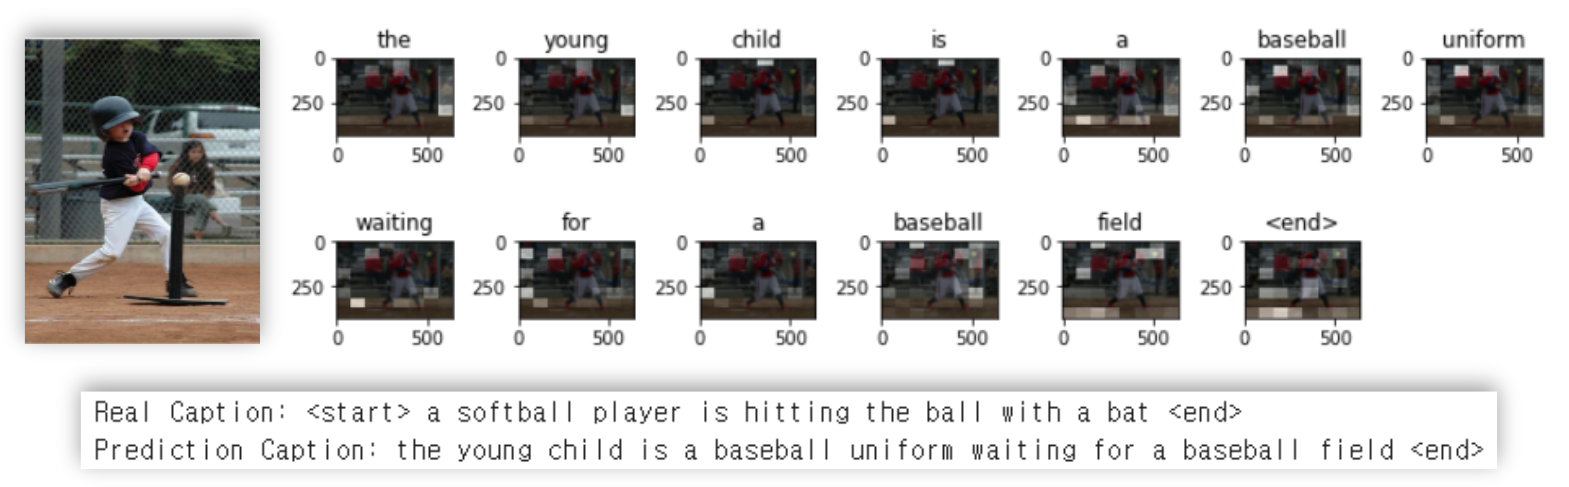

이미지 캡셔닝은 이미지가 지닌 정보를 설명해주는 한 문장을 설명하는 기술입니다.이미지 캡셔닝은 영상, 이미지를 처리하는 컴퓨터 비전, 그리고 자연어 처리라는 인공지능의 큰 축인 두 분야를 연결해주는 중요한 의의를 갖는 연구입니다. 기존의 주어진 연구들은 주로 이미지를 입력받아 영어 문장을 생성해냈다면, 저희는 이를 한국어로 문장을 생성하고자 합니다

이 모델은  [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) 논문을 기반으로 합니다.

이 노트북 파일은 End-To-End 파일입니다. [MS COCO 2014 Dataset](https://cocodataset.org/#download)을 프로그램에서 자체적으로 다운로드하고, [AI HUB에서 제공한 한국어 Annotation File을 (편집 과정을 일부 거쳤음)](https://aihub.or.kr/keti_data_board/visual_intelligence_)을 이용자가 직접 업로드하면, Resnet-101을 이용해 이미지를 전처리 및 캐시 처리한 후, 추출해낸 Feature 값을 LSTM에 입력해 모델을 훈련합니다. 훈련된 모델을 활용해 새로운 이미지에 대한 캡션을 생성하고, 이를 BLEU 기준을 통해 평가하는 것까지가 하나의 프로그램이 될 것입니다. 




In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (36.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and di

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import pandas as pd
import os
import time
import json
from PIL import Image

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

plt.rc('font', family = 'NanumBarunGothic')

## MS-COCO 데이터셋 다운로드 및 준비

[MS-COCO 2014 데이터셋](http://cocodataset.org/#home)을 다운로드합니다. 그리고 다운로드받은 파일의 압축을 해제하고 각각 train2014, val2014 폴더로 저장합니다. 이 코드에서 caption file을 다운로드받기는 하지만, 이 파일은 영어로 이루어진 caption 파일로 이 코드 내에서는 활용되지 않습니다.

만일 Colab에서 다음을 실행시킬 경우, 파일에 'captions_kor_train.json' 파일과 'captions_kor_val.json' 파일을 업로드해줍니다. 만일 로컬 PC에서 동작시키실 경우, 후에 두 annotation file의 경로를 지정해주면 됩니다.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 406s 0us/step


In [ ]:
image_folder ='train2014/'
PATH = image_folder

만일 Local PC에서 이 프로그램을 동작시킬 경우, annotation_file에 'captions_kor_train.json' 파일의 경로를 입력해주어 연결시켜줍니다.

In [ ]:
annotation_file = 'captions_kor_train.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

image_folder ='train2014/'
PATH = image_folder

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# 용량 제한을 두어 30,000개의 캡션(6,000개의 이미지)만 사용할 수도 있습니다.
train_image_paths = image_paths#[:6000]
print(len(train_image_paths))

82783


In [ ]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

## ResNet101 사용하여 이미지 전처리하기

다음으로, (Imagenet에 대해 사전 훈련된) ResNet101을 사용하여 이미지를 분류하고 마지막 Convolutional Layer에서 특징을 추출해냅니다.

- 이미지를 299px x 299px로 resize합니다.
- [ResNet101 설명](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/ResNet101)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, image_path

## ResNet101 초기화 및 사전 훈련된 Imagenet 가중치 로드하기

이제 Output Layer가 InceptionV3의 마지막 Convolutional Layer인 tf.keras 모델을 만듭니다.

- 네트워크를 통해 각 이미지를 전달하고 결과 벡터를 사전 (image_name --&gt; feature_vector)에 저장합니다.
- 모든 이미지가 네트워크를 통해 전달된 후, 사전을 디스크에 저장합니다.

In [ ]:
image_model = tf.keras.applications.ResNet101(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

171458560/171446536 [==============================] - 3s 0us/step


## ResNet101에서 추출된 특성 캐시하기

ResNet101로 각 이미지를 사전 처리하고 출력을 디스크에 캐시합니다. 현재 코드보다 정교한 캐싱 전략(ex. 임의 액세스 디스크 I/O를 줄이기 위해 이미지 분할 등)으로 성능을 향상할 수 있습니다.


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## 캡션 전처리 및 토큰화하기

- 캡션을 토큰화합니다. 그리고 최대 단어의 크기를 상위 10,000개 단어로 제한합니다. 
그 단어 이외의 단어들은 토큰 "UNK"(알 수 없음)로 대체됩니다.
- 그 후, 단어 대 인덱스 및 인덱스 대 단어 매핑을 만듭니다.
- 마지막으로, 모든 시퀀스를 가장 긴 시퀀스와 같은 길이로 채웁니다.

In [ ]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 10,000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## 데이터를 훈련(Train) 및 평가(Validation) 데이터셋로 분할하기




In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80:20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

## 훈련을 위한 tf.data 데이터세트 생성하기


이미지와 캡션이 준비되었습니다. 다음으로 모델 훈련에 사용할 `tf.data` 데이터세트를 만듭니다.

In [ ]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from ResNet101 is (100, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 100

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## 모델

모델은 Encoder로 CNN을 Decoder로 RNN을 활용합니다. 
- CNN에서는 이미지의 Feature들을 추출해낸 후, 
- 추출한 Feature들을 RNN을 통해서 단어 토큰으로 출력하는 구조로 이루어집니다. 

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 100, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 100, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 100, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 100, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 100, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 체크포인트

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## 훈련하기

- 각 `.npy` 파일에 저장된 특성을 추출한 다음, 해당 특성을 endcoder를 통해 전달합니다.
- encoder의 출력값, decoder의 hidden state(0으로 초기화됨) 및 입력값(start token)이 decoder로 전달됩니다.
- decoder는 예측값 및 decoder hidden state를 반환합니다.
- 그 후 decoder hidden state가 모델로 다시 전달되고, 예측값은 손실을 계산하는 데 사용됩니다. 
- teacher forcing를 사용하여 decoder에 대한 다음 입력을 결정합니다. teacher forcing은 출력값이, 다음 입력값으로 decoder에 전달되는 기법입니다.
- 마지막으로 Gradient를 계산하고 이를 Optimizer에 적용하여 Back-propagation합니다.


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

- Epoch는 다음 학습을 몇 번 반복할 지를 결정합니다. 
- Default 값으로는 20번으로 지정되어있습니다.
- 이용자가 원하는 만큼 지정해서 성능을 향상시킵니다.

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0632
Epoch 1 Batch 100 Loss 1.2106
Epoch 1 Batch 200 Loss 1.2654
Epoch 1 Batch 300 Loss 1.0784
Epoch 1 Batch 400 Loss 1.0575
Epoch 1 Batch 500 Loss 0.9951
Epoch 1 Batch 600 Loss 1.1075
Epoch 1 Batch 700 Loss 0.9777
Epoch 1 Batch 800 Loss 0.8211
Epoch 1 Batch 900 Loss 0.9895
Epoch 1 Batch 1000 Loss 0.9064
Epoch 1 Batch 1100 Loss 0.9303
Epoch 1 Batch 1200 Loss 0.9305
Epoch 1 Batch 1300 Loss 0.9032
Epoch 1 Batch 1400 Loss 0.8770
Epoch 1 Batch 1500 Loss 0.8935
Epoch 1 Batch 1600 Loss 0.8311
Epoch 1 Batch 1700 Loss 0.8955
Epoch 1 Batch 1800 Loss 0.8634
Epoch 1 Batch 1900 Loss 0.8041
Epoch 1 Batch 2000 Loss 0.8883
Epoch 1 Batch 2100 Loss 0.9786
Epoch 1 Batch 2200 Loss 0.8537
Epoch 1 Batch 2300 Loss 0.8482
Epoch 1 Batch 2400 Loss 0.8331
Epoch 1 Batch 2500 Loss 0.7587
Epoch 1 Batch 2600 Loss 0.7963
Epoch 1 Batch 2700 Loss 0.8187
Epoch 1 Batch 2800 Loss 0.8570
Epoch 1 Batch 2900 Loss 0.8463
Epoch 1 Batch 3000 Loss 0.8472
Epoch 1 Batch 3100 Loss 0.7830
Epoch 1 Batch 3200 L

In [ ]:
print(loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.8881398>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7465124>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7032771>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6707405>, <tf.Tensor: shape=(), dtype=float32, numpy=0.64232236>, <tf.Tensor: shape=(), dtype=float32, numpy=0.616263>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5916981>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5691614>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5487152>, <tf.Tensor: shape=(), dtype=float32, numpy=0.53020644>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5132416>, <tf.Tensor: shape=(), dtype=float32, numpy=0.49844095>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4850709>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4735096>, <tf.Tensor: shape=(), dtype=float32, numpy=0.462874>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4536006>, <tf.Tensor: shape=(), dtype=float32, numpy=0.44490096>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4374341>, <tf.Ten

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
### val epoch
val_loss_plot = []
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.9662
Epoch 1 Batch 100 Loss 0.8164
Epoch 1 Batch 200 Loss 0.9485
Epoch 1 Batch 300 Loss 0.8207
Epoch 1 Batch 400 Loss 0.7684
Epoch 1 Batch 500 Loss 0.8549
Epoch 1 Batch 600 Loss 0.8619
Epoch 1 Batch 700 Loss 0.7285
Epoch 1 Batch 800 Loss 0.7718
Epoch 1 Batch 900 Loss 0.7036
Epoch 1 Batch 1000 Loss 0.7945
Epoch 1 Loss 0.202479
Time taken for 1 epoch 191.56 sec

Epoch 2 Batch 0 Loss 0.6934
Epoch 2 Batch 100 Loss 0.6103
Epoch 2 Batch 200 Loss 0.7125
Epoch 2 Batch 300 Loss 0.6486
Epoch 2 Batch 400 Loss 0.6189
Epoch 2 Batch 500 Loss 0.6827
Epoch 2 Batch 600 Loss 0.7148
Epoch 2 Batch 700 Loss 0.6344
Epoch 2 Batch 800 Loss 0.8041
Epoch 2 Batch 900 Loss 0.6594
Epoch 2 Batch 1000 Loss 0.6396
Epoch 2 Loss 0.169607
Time taken for 1 epoch 161.86 sec

Epoch 3 Batch 0 Loss 0.6371
Epoch 3 Batch 100 Loss 0.5693
Epoch 3 Batch 200 Loss 0.5310
Epoch 3 Batch 300 Loss 0.5639
Epoch 3 Batch 400 Loss 0.5685
Epoch 3 Batch 500 Loss 0.6076
Epoch 3 Batch 600 Loss 0.5993
Epoch 3 Batch 700 Lo

In [ ]:
print(val_loss_plot)

[<tf.Tensor: shape=(), dtype=float32, numpy=0.20247947>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16960734>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1514795>, <tf.Tensor: shape=(), dtype=float32, numpy=0.13504796>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12025572>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10743044>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09685236>, <tf.Tensor: shape=(), dtype=float32, numpy=0.08787549>, <tf.Tensor: shape=(), dtype=float32, numpy=0.080376014>, <tf.Tensor: shape=(), dtype=float32, numpy=0.074566916>, <tf.Tensor: shape=(), dtype=float32, numpy=0.069617145>, <tf.Tensor: shape=(), dtype=float32, numpy=0.066672035>, <tf.Tensor: shape=(), dtype=float32, numpy=0.06158419>, <tf.Tensor: shape=(), dtype=float32, numpy=0.057720404>, <tf.Tensor: shape=(), dtype=float32, numpy=0.055552278>, <tf.Tensor: shape=(), dtype=float32, numpy=0.053244464>, <tf.Tensor: shape=(), dtype=float32, numpy=0.051164594>, <tf.Tensor: shape=(), dtype=float32, num

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


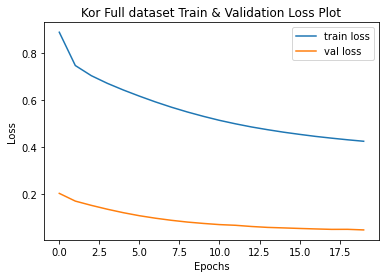

In [ ]:
# Train & Validation Loss Plot
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

## 캡셔닝

- 각 타임스텝에서 decoder는 Decoder의 hidden state, encoder 출력값 그리고 이전 예측값을 입력값으로 받습니다.
- 모델이 end 토큰을 예측하면 예측이 중지됩니다.
- 그리고 타임스텝마다 attention 가중치를 저장합니다.

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        
        #grid_size = max(np.ceil(len_result/2), 2)
        grid_size = max(np.ceil(len_result/4), 4)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.5, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# TEST 단계


Test를 수행하기 위한 MS-COCO 2014 Validation set을 다운로드합니다.

In [ ]:
# Download image files
image_folder = '/val2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('val2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/val2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

6645022720/6645013297 [==============================] - 183s 0us/step


 그리고 annotation_file 에 이전에 train caption file의 경로를 지정했듯, val caption file의 경로를 지정합니다

In [ ]:
annotation_file = 'captions_kor_validation.json' #s.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

kor_json = annotations

kor_val_caption = []
for i in range(len(kor_json['annotations'])):
    for j in range(len(kor_json['annotations'][i])):
      caption = {'caption': kor_json['annotations'][i]['caption'],
                 'id': str(kor_json['annotations'][i]['id']).zfill(12), #'{0:12d}'.format(kor_json[i]['id']),
                 #'id' : kor_json[i]['id'],
                 'image_id' : kor_json['annotations'][i]['id']}
      kor_val_caption.append(caption)
print(len(kor_val_caption))
annotations['annotations'] = kor_val_caption

486048


In [ ]:
df = pd.DataFrame(kor_val_caption)
df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
grouped_df = df.groupby("id")

grouped_lists = grouped_df["caption"].agg(lambda column: "^".join(column))

df = grouped_lists.to_frame()
captions = df['caption'].str.split('^').tolist()
val_df = pd.DataFrame(captions)
val_df.index = grouped_lists.index

kor_val_caption = val_df.values.tolist()

val_df = val_df.loc[:, ~val_df.T.duplicated()]

BLEU를 계산합니다. 
- BLEU는 기계가 생성해낸 텍스트와 인간의 텍스트 간의 유사도를 수치화한 결과 값입니다. 
- BLEU에 대한 자세한 설명은 다음 [WikiPedia](https://en.wikipedia.org/wiki/BLEU) 정보를 참고. 

In [ ]:
## BLEU 계산

bleu_avg = 0
bleu_1 = 0
bleu_2 = 0
bleu_3 = 0
bleu_4 = 0

for i in range(len(kor_val_caption)):
  image_path = 'val2014/COCO_val2014_{}.jpg'.format(val_df.index[i])

  result, attention_plot = evaluate(image_path)

  reference = list(map(lambda ref: ref.split(), kor_val_caption[i]))

  candidate =  result[:-1]

  smooth = SmoothingFunction()
  score_avg = sentence_bleu(reference,candidate, smoothing_function=smooth.method1, weights=(0.25,0.25,0.25,0.25))
  score_1 = sentence_bleu(reference,candidate, smoothing_function=smooth.method1, weights=(1,0,0,0))
  score_2 = sentence_bleu(reference,candidate, smoothing_function=smooth.method1, weights=(0,1,0,0))
  score_3 = sentence_bleu(reference,candidate, smoothing_function=smooth.method1, weights=(0,0,1,0))
  score_4 = sentence_bleu(reference,candidate, smoothing_function=smooth.method1, weights=(0,0,0,1))

  bleu_1 = bleu_1 + score_1
  bleu_2 = bleu_2 + score_2
  bleu_3 = bleu_3 + score_3
  bleu_4 = bleu_4 + score_4
  bleu_avg = bleu_avg + score_avg

bleu_1 = bleu_1 / len(kor_val_caption) * 100
bleu_2 = bleu_2 / len(kor_val_caption) * 100
bleu_3 = bleu_3 / len(kor_val_caption) * 100
bleu_4 = bleu_4 / len(kor_val_caption) * 100
bleu_avg = bleu_avg / len(kor_val_caption) * 100

print('bleu_1 : ' , bleu_1)
print('bleu_2 : ' , bleu_2)
print('bleu_3 : ' , bleu_3)
print('bleu_4 : ' , bleu_4)
print('bleu_avg : ', bleu_avg)

bleu_1 :  22.434685115158974
bleu_2 :  6.125320280244992
bleu_3 :  2.6111059272448696
bleu_4 :  2.2729331742836822
bleu_avg :  4.458596878843663


In [ ]:
values = [bleu_1, bleu_2, bleu_3, bleu_4, bleu_avg]
values

[22.434685115158974,
 6.125320280244992,
 2.6111059272448696,
 2.2729331742836822,
 4.458596878843663]

(array([ 0.,  5., 10., 15., 20., 25.]),
 <a list of 6 Text major ticklabel objects>)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


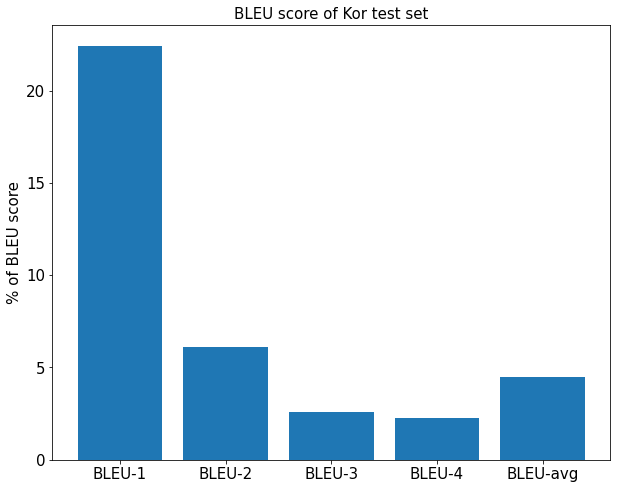

In [ ]:
# BLEU visualizatoin

column = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'BLEU-avg']
values = [bleu_1, bleu_2, bleu_3, bleu_4, bleu_avg]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
bar = plt.bar(column, values, align='center')
plt.title('BLEU score of Kor test set', fontsize = 15)
plt.ylabel('% of BLEU score', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

# 추가 실험
- 이 모델에게 새로운 이미지를 주고, 제대로 학습이 이루어졌는지 확인해봅시다. 
- 아 물론, COCO Dataset 이외의 데이터를 주게 되면, 실험 결과가 부정확할 확률이 높지만, 재미로 해봅시다. 
- 아래 URL을 바꾸면 이미지를 바꿀 수 있습니다. 

57344/43024 [=======================================] - 0s 0us/step
Prediction Caption: 흰 스웨터를 입은 작은 소녀가 잔디 위에 흰 원반을 잡는다 <end>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50920 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51077 missing from current font.
  font.set_

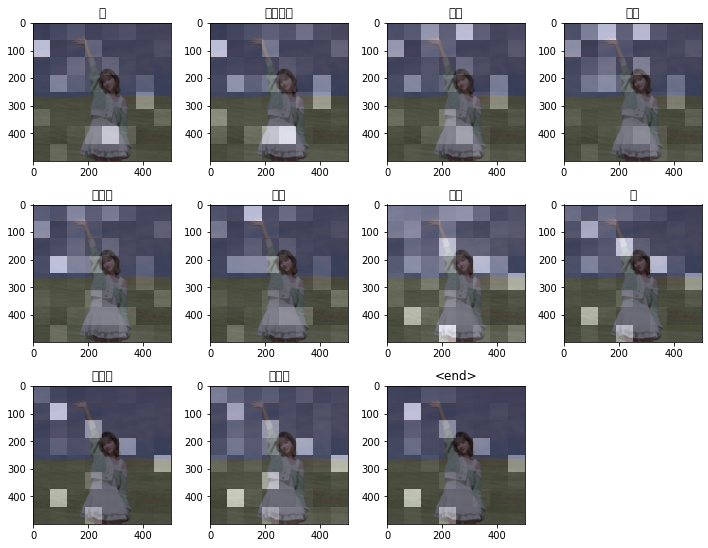

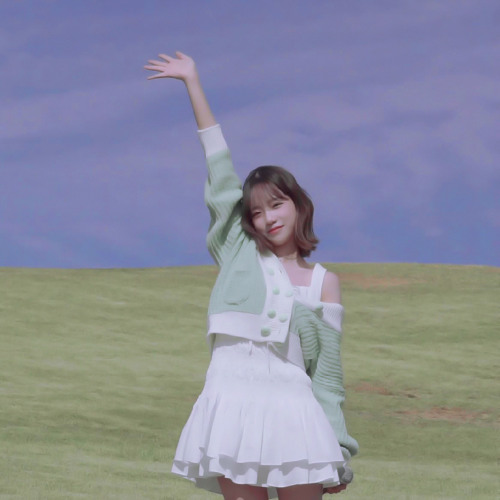

In [ ]:
image_url = 'https://i1.sndcdn.com/artworks-jK5rq85ivARYrQ7o-8ZlcRA-t500x500.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)